# Alloy Stress-Thickness Fitting: V-Mo System

This notebook demonstrates the alloy extension workflow for fitting stress-thickness
curves in the V-Mo binary alloy system. We fit pure V and Mo simultaneously with
V-25Mo, V-50Mo, and V-75Mo alloys, where the energetic parameters (A0, B0, l0) for
alloys are blended from pure elements via rule of mixtures.

**Materials:** V, Mo (pure elements) + V-25Mo, V-50Mo, V-75Mo (alloys)  
**Data source:** Su (unpublished)

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

import torch
import torch.nn as nn

%matplotlib inline

# Add repo root to path
REPO_ROOT = Path('..').resolve().parent
sys.path.insert(0, str(REPO_ROOT))
from kmorfs import load_from_database, AlloyMaterialDependentExtension, AlloySTFModel

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.7.1+cpu
CUDA available: False


In [2]:
# ===== Configuration =====
# Pure elements MUST be listed before alloys
MATERIALS = ["V", "Mo", "V-25Mo", "V-50Mo", "V-75Mo"]
DATA_SOURCES = ["Su"]
N_PURE_ELEMENTS = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
SOURCE_CSV = REPO_ROOT / "data" / "source.csv"
EXPERIMENTS_CSV = REPO_ROOT / "data" / "all_experiments.csv"

# Default initial guesses per material
MATERIAL_DEFAULTS = {
    "V": {
        "K0": 0, "alpha1": 0.02, "L0": 10, "GrainSize_200": 18.05,
        "Sigma0": 10, "BetaD": 0.001, "Mfda": 0.01, "Di": 0.02,
        "A0": -2, "B0": -9, "l0": 1.128,
    },
    "Mo": {
        "K0": 0, "alpha1": 0.02, "L0": 10, "GrainSize_200": 15.0,
        "Sigma0": 10, "BetaD": 0.05, "Mfda": 20, "Di": 0.3,
        "A0": -3, "B0": -8, "l0": 0.8,
    },
}
DEFAULT_PARAMS = {
    "K0": 0, "alpha1": 0.02, "L0": 10, "GrainSize_200": 15,
    "Sigma0": 10, "BetaD": 0.05, "Mfda": 20, "Di": 0.3,
    "A0": -3, "B0": -8, "l0": 0.8,
}

# Plot colors
COLORS = np.array([
    "#5B9BD5", "#A5D6A7", "#F1C40F", "#E74C3C",
    "#9B59B6", "#F39C12", "#1F77B4", "#BDC3C7"
])

try:
    matplotlib.rcParams['font.family'] = "Times New Roman"
except Exception:
    pass

print(f"Device: {DEVICE}")
print(f"Materials: {MATERIALS}")
print(f"Pure elements: {MATERIALS[:N_PURE_ELEMENTS]}")

Device: cpu
Materials: ['V', 'Mo', 'V-25Mo', 'V-50Mo', 'V-75Mo']
Pure elements: ['V', 'Mo']


In [3]:
# Load experimental data from database
fit_data, process_condition, experiment_labels = load_from_database(
    source_path=SOURCE_CSV,
    experiments_path=EXPERIMENTS_CSV,
    materials=MATERIALS,
    data_sources=DATA_SOURCES,
)

print(f"Found {len(experiment_labels)} experiments:")
for label in experiment_labels:
    print(f"  {label}")
print(f"\nTotal data points: {len(fit_data)}")
print(f"\nProcess conditions:")
display(process_condition)

Found 29 experiments:
  V_Su_R0.04_T295_P0.27
  V_Su_R0.06_T295_P0.27
  V_Su_R0.02_T295_P0.27
  V_Su_R0.26_T295_P0.27
  V_Su_R0.16_T295_P0.27
  V_Su_R0.12_T295_P0.27
  V_Su_R0.1_T295_P0.27
  V_Su_R0.08_T295_P0.27
  V_Su_R0.36_T295_P0.27
  Mo_Su_R0.36_T295_P0.27
  Mo_Su_R0.2_T295_P0.27
  Mo_Su_R0.28_T295_P0.27
  Mo_Su_R0.08_T295_P0.27
  Mo_Su_R0.12_T295_P0.27
  V-25Mo_Su_R0.08_T295_P0.27
  V-25Mo_Su_R0.12_T295_P0.27
  V-25Mo_Su_R0.2_T295_P0.27
  V-25Mo_Su_R0.28_T295_P0.27
  V-25Mo_Su_R0.36_T295_P0.27
  V-50Mo_Su_R0.08_T295_P0.27
  V-50Mo_Su_R0.12_T295_P0.27
  V-50Mo_Su_R0.2_T295_P0.27
  V-50Mo_Su_R0.36_T295_P0.27
  V-50Mo_Su_R0.5_T295_P0.27
  V-75Mo_Su_R0.08_T295_P0.27
  V-75Mo_Su_R0.12_T295_P0.27
  V-75Mo_Su_R0.2_T295_P0.27
  V-75Mo_Su_R0.28_T295_P0.27
  V-75Mo_Su_R0.36_T295_P0.27

Total data points: 290

Process conditions:


,R,T,P,Melting_T
0,0.04,295,0.27,2183.00
1,0.06,295,0.27,2183.00
2,0.02,295,0.27,2183.00
3,0.26,295,0.27,2183.00
4,0.16,295,0.27,2183.00
5,0.12,295,0.27,2183.00
6,0.10,295,0.27,2183.00
7,0.08,295,0.27,2183.00
8,0.36,295,0.27,2183.00
9,0.36,295,0.27,2896.00


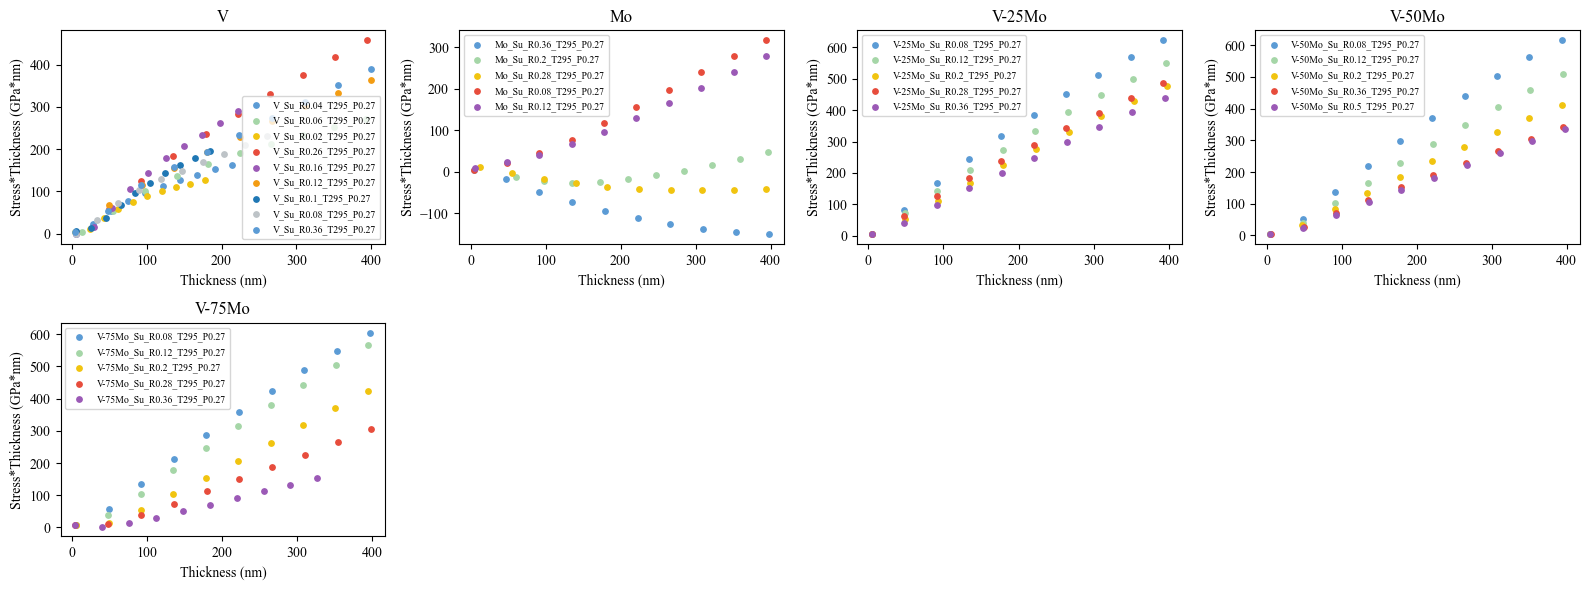

In [4]:
# Plot raw stress-thickness curves
melting_vals = process_condition['Melting_T'].unique()
material_names = [label.split('_')[0] for label in experiment_labels]

n_plots = len(melting_vals)
n_cols = min(4, n_plots)
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
if n_plots == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes.reshape(1, -1)

melting_to_material = {}
for i, mt in enumerate(process_condition['Melting_T'].values):
    if mt not in melting_to_material:
        melting_to_material[mt] = material_names[i]

for i, tm in enumerate(melting_vals):
    r, c = divmod(i, n_cols)
    ax = axes[r, c]
    matching = process_condition[process_condition['Melting_T'] == tm].index.tolist()
    for j, idx in enumerate(matching):
        mask = fit_data["Index"] == idx + 1
        ax.scatter(fit_data.loc[mask, "thickness"], fit_data.loc[mask, "StressThickness"],
                   color=COLORS[j % len(COLORS)], s=15, label=experiment_labels[idx])
    ax.set_title(melting_to_material[tm])
    ax.set_xlabel("Thickness (nm)")
    ax.set_ylabel("Stress*Thickness (GPa*nm)")
    ax.legend(fontsize=7)

for j in range(n_plots, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])
plt.tight_layout()
plt.show()

In [5]:
# Build config and setup parameters

def get_material_params(material):
    return MATERIAL_DEFAULTS.get(material, DEFAULT_PARAMS).copy()

def build_config(process_condition, experiment_labels):
    material_names = [label.split('_')[0] for label in experiment_labels]
    process_cols = ['K0']
    material_cols = ['alpha1', 'L0', 'GrainSize_200', 'Sigma0', 'BetaD', 'Mfda', 'Di', 'A0', 'B0', 'l0']
    rows = []
    seen_materials = set()
    for i, label in enumerate(experiment_labels):
        mat = material_names[i]
        params = get_material_params(mat)
        mt = process_condition.iloc[i]['Melting_T']
        row = {
            'Fit_data': label,
            'R': process_condition.iloc[i]['R'],
            'T': process_condition.iloc[i]['T'],
            'P': process_condition.iloc[i]['P'],
            'Melting_T': mt,
            'SigmaC': 0,
        }
        for col in process_cols:
            row[col] = params[col]
        if mt not in seen_materials:
            for col in material_cols:
                row[col] = params[col]
            seen_materials.add(mt)
        else:
            for col in material_cols:
                row[col] = np.nan
        rows.append(row)
    return pd.DataFrame(rows)

def setup_parameters(mainfile):
    process_condition = mainfile[['R', 'T', 'P', 'Melting_T']]
    initial_process = mainfile[['K0']]
    material_cols = ['alpha1', 'L0', 'GrainSize_200', 'Sigma0', 'BetaD', 'Mfda', 'Di', 'A0', 'B0', 'l0']
    initial_materials = mainfile[material_cols].dropna()
    materials_1d = initial_materials.values.flatten()
    process_1d = initial_process.values.flatten()
    x_vector = np.concatenate([materials_1d, process_1d])
    materials_bound = np.array([3, 2, 0.5, 3, 2, 0.5, 2, 2, 0.5, 0.2])
    process_bound = np.array([300])
    materials_lb = initial_materials.copy().astype(float)
    materials_ub = initial_materials.copy().astype(float)
    for i in [0, 1, 4, 6]:
        mater_f1 = 0
        mater_f2 = initial_materials.iloc[:, i] * (1 + materials_bound[i])
        materials_lb.iloc[:, i] = np.minimum(mater_f1, mater_f2)
        materials_ub.iloc[:, i] = np.maximum(mater_f1, mater_f2)
    for i in [2, 3, 5, 7, 8, 9]:
        mater_f1 = initial_materials.iloc[:, i] * (1 / (1 + materials_bound[i]))
        mater_f2 = initial_materials.iloc[:, i] * (1 + materials_bound[i])
        materials_lb.iloc[:, i] = np.minimum(mater_f1, mater_f2)
        materials_ub.iloc[:, i] = np.maximum(mater_f1, mater_f2)
    process_lb = initial_process.copy().astype(float)
    process_ub = initial_process.copy().astype(float)
    process_lb.iloc[:, 0] = initial_process.iloc[:, 0] - process_bound[0]
    process_ub.iloc[:, 0] = initial_process.iloc[:, 0] + process_bound[0]
    para_lb = np.concatenate([materials_lb.values.flatten(), process_lb.values.flatten()])
    para_ub = np.concatenate([materials_ub.values.flatten(), process_ub.values.flatten()])
    degenerate = para_lb == para_ub
    para_ub[degenerate] = para_lb[degenerate] + 1e-3
    x_vector_scaled = (x_vector - para_lb) / (para_ub - para_lb)
    file_setting = [N_PURE_ELEMENTS, len(process_bound), len(materials_bound)]
    return {
        'x_vector_scaled': x_vector_scaled,
        'para_lb': para_lb,
        'para_ub': para_ub,
        'process_condition': process_condition,
        'initial_process': initial_process,
        'initial_materials': initial_materials,
        'process_para_name': 'K0',
        'materials_para_name': material_cols,
        'materials_bound': materials_bound,
        'process_bound': process_bound,
        'file_setting': file_setting,
    }

mainfile = build_config(process_condition, experiment_labels)
alloy_ext = AlloyMaterialDependentExtension(mainfile)
params = setup_parameters(mainfile)

print(f"Unique materials: {alloy_ext.unique}")
print(f"Pure elements: {alloy_ext.single_el}")
print(f"file_setting: {params['file_setting']}")
print(f"Parameter vector length: {len(params['x_vector_scaled'])}")

Unique materials: ['V', 'Mo', 'V-25Mo', 'V-50Mo', 'V-75Mo']
Pure elements: ['V', 'Mo']
file_setting: [2, 1, 10]
Parameter vector length: 79


In [6]:
# Scale data and create tensors
x_data = fit_data["thickness"]
y_data = fit_data["StressThickness"]

scaler_x = MinMaxScaler(feature_range=(0.1, 1.1))
scaler_rawy = MinMaxScaler(feature_range=(0.1, 1.1))
scaler_fity = MinMaxScaler(feature_range=(0.1, 1.1))

x_scaled = scaler_x.fit_transform(x_data.to_numpy().reshape(-1, 1)).flatten()
y_scaled = scaler_rawy.fit_transform(y_data.to_numpy().reshape(-1, 1)).flatten()
scaler_fity.fit(y_data.to_numpy().reshape(-1, 1))

x_tensor = torch.tensor(x_scaled, dtype=torch.float32).to(DEVICE)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32).to(DEVICE)
process_tensor = torch.tensor(params['process_condition'].to_numpy(),
                              dtype=torch.float32).to(DEVICE)
fit_index_tensor = torch.tensor(fit_data["Index"].to_numpy(),
                                dtype=torch.long).to(DEVICE)

print(f"x_tensor shape: {x_tensor.shape}")
print(f"y_tensor shape: {y_tensor.shape}")
print(f"process_tensor shape: {process_tensor.shape}")
print(f"fit_index_tensor unique: {fit_index_tensor.unique().tolist()}")

x_tensor shape: torch.Size([290])
y_tensor shape: torch.Size([290])
process_tensor shape: torch.Size([29, 4])
fit_index_tensor unique: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [7]:
# Initialize model and train
model = AlloySTFModel(
    x0=params['x_vector_scaled'],
    para_lb=params['para_lb'],
    para_ub=params['para_ub'],
    mainfile=mainfile,
    file_setting=params['file_setting'],
).to(DEVICE)

# LBFGS training
optimizer = torch.optim.LBFGS(
    model.parameters(), lr=0.1, max_iter=20,
    history_size=10, line_search_fn="strong_wolfe"
)
loss_fn = nn.MSELoss()

def closure():
    optimizer.zero_grad()
    y_pred = model(x_tensor, process_tensor, fit_index_tensor, scaler_x, scaler_fity)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    return loss

print("Training model...")
for epoch in range(26):
    loss = optimizer.step(closure)
    if epoch % 5 == 0:
        print(f"  Epoch {epoch:3d}, Loss: {loss.item() * 100:.5f}")

Training model...
  Epoch   0, Loss: 10.02211
  Epoch   5, Loss: 0.07015
  Epoch  10, Loss: 0.04064
  Epoch  15, Loss: 0.03788
  Epoch  20, Loss: 0.03699
  Epoch  25, Loss: 0.03682


In [8]:
# Evaluate and inverse-scale predictions
model.eval()
with torch.no_grad():
    y_pred_scaled = model(x_tensor, process_tensor, fit_index_tensor,
                          scaler_x, scaler_fity)

y_pred = scaler_fity.inverse_transform(
    y_pred_scaled.cpu().numpy().reshape(-1, 1)
).flatten()
fit_data['y_pred'] = y_pred

print(f"Prediction range: [{y_pred.min():.3f}, {y_pred.max():.3f}] GPa*nm")
print(f"Experimental range: [{y_data.min():.3f}, {y_data.max():.3f}] GPa*nm")

Prediction range: [-157.440, 630.109] GPa*nm
Experimental range: [-150.345, 622.898] GPa*nm


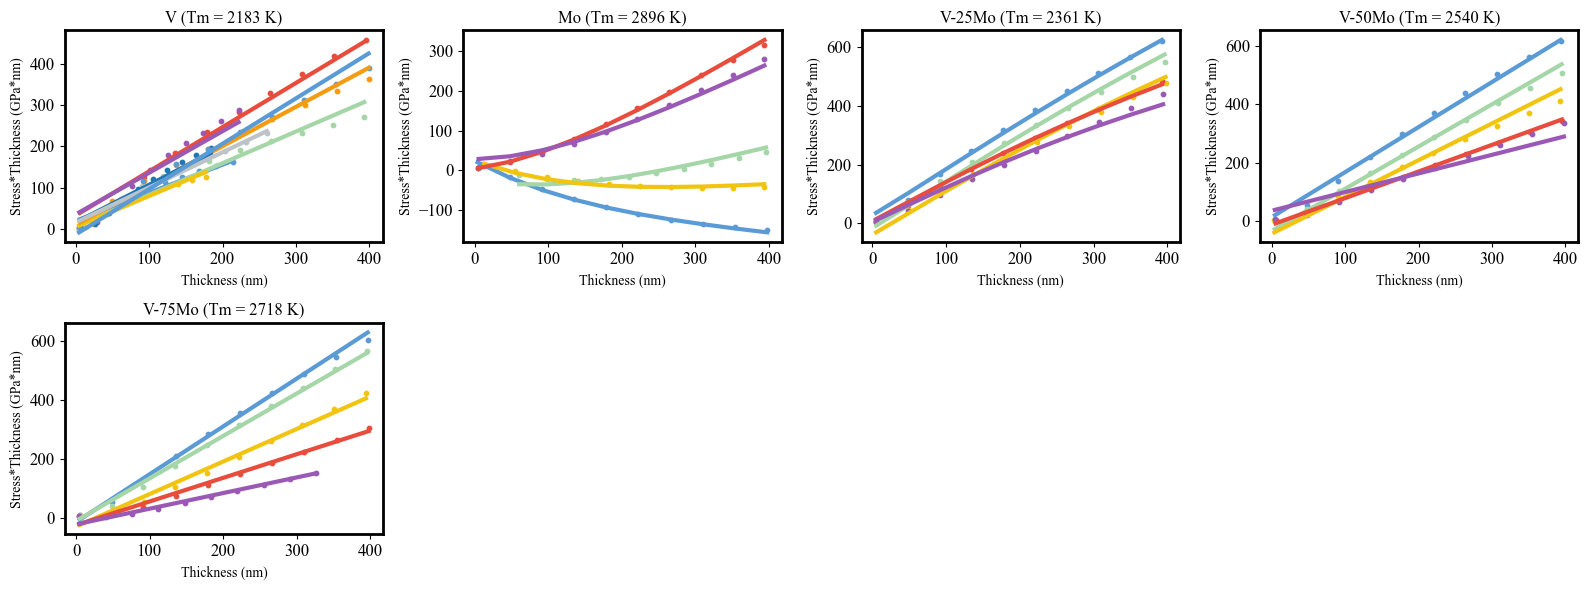

In [9]:
# Plot fitted vs experimental results
melting_vals = params['process_condition']['Melting_T'].unique()
n_plots = len(melting_vals)
n_cols = min(4, n_plots)
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
if n_plots == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes.reshape(1, -1)

for i, tm in enumerate(melting_vals):
    r, c = divmod(i, n_cols)
    ax = axes[r, c]
    matching_rows = params['process_condition'][params['process_condition']['Melting_T'] == tm].index.tolist()
    color_id = 0
    for dataset_id in matching_rows:
        mask = fit_data["Index"] == dataset_id + 1
        thickness = fit_data.loc[mask, "thickness"].reset_index(drop=True)
        raw_data = fit_data.loc[mask, "StressThickness"].reset_index(drop=True)
        pred_data = fit_data.loc[mask, "y_pred"].reset_index(drop=True)
        ax.plot(thickness, pred_data, color=COLORS[color_id], linewidth=3)
        ax.scatter(thickness, raw_data, color=COLORS[color_id], s=10)
        color_id = (color_id + 1) % len(COLORS)
    ax.set_title(f"{alloy_ext.unique[i]} (Tm = {tm:.0f} K)")
    ax.set_xlabel("Thickness (nm)")
    ax.set_ylabel("Stress*Thickness (GPa*nm)")
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.tick_params(labelsize=12)

for j in range(n_plots, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])
plt.tight_layout()
plt.show()

In [10]:
# Extract and display optimized parameters
with torch.no_grad():
    optimized_scaled = model.x_vector_scaled.cpu().numpy()

para_lb, para_ub = params['para_lb'], params['para_ub']
vector_param = optimized_scaled * (para_ub - para_lb) + para_lb

melting_temps = params['process_condition']['Melting_T'].values
unique_temps = list(dict.fromkeys(melting_temps))
num_materials = len(unique_temps)
materials_bound = params['materials_bound']
process_bound = params['process_bound']

mat_count = num_materials * len(materials_bound)
partial_materials = vector_param[:mat_count].reshape(num_materials, len(materials_bound))

# Apply alloy extension (blend A0, B0, l0 for alloys)
materials_para = alloy_ext.alloy_extension(partial_materials, partial_materials[:N_PURE_ELEMENTS, -3:])

n_data = (len(vector_param) - mat_count) // len(process_bound)
process_para = vector_param[mat_count:].reshape(n_data, len(process_bound))

# Display material parameters
mat_df = pd.DataFrame(materials_para, columns=params['materials_para_name'],
                       index=alloy_ext.unique)
print("Optimized Material Parameters:")
display(mat_df)

# Display process parameters
proc_df = pd.DataFrame(process_para, columns=[params['process_para_name']],
                        index=experiment_labels)
print("\nOptimized Process Parameters (K0):")
display(proc_df)

Optimized Material Parameters:


,alpha1,L0,GrainSize_200,Sigma0,BetaD,Mfda,Di,A0,B0,l0
V,0.044974,24.150953,20.222213,24.457815,2.557684e-03,0.011656,0.008085,-1.339454,-6.000001,0.940002
Mo,0.079994,7.693500,10.000003,2.500025,1.844381e-08,29.999990,0.264920,-1.008115,-5.333339,0.666692
V-25Mo,0.057617,13.351516,22.120462,8.207944,5.961450e-03,14.223775,0.899999,-1.256619,-5.833335,0.871675
V-50Mo,0.049813,26.901823,16.611761,11.132424,4.758982e-06,25.545394,0.900000,-1.173785,-5.666670,0.803347
V-75Mo,0.073360,29.999303,17.110571,13.766950,8.214184e-09,29.182815,0.400687,-1.090950,-5.500004,0.735020



Optimized Process Parameters (K0):


,K0
V_Su_R0.04_T295_P0.27,23.342299
V_Su_R0.06_T295_P0.27,16.057563
V_Su_R0.02_T295_P0.27,8.118546
V_Su_R0.26_T295_P0.27,38.880515
V_Su_R0.16_T295_P0.27,40.241969
V_Su_R0.12_T295_P0.27,15.235412
V_Su_R0.1_T295_P0.27,21.164417
V_Su_R0.08_T295_P0.27,19.843340
V_Su_R0.36_T295_P0.27,-8.408815
Mo_Su_R0.36_T295_P0.27,19.761658
